# I. Import Libraries

In [20]:
import torch
from tqdm import tqdm
import os
import json
import pandas as pd
import seaborn as sns
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import GATConv, GINConv, global_mean_pool
from transformers import RobertaTokenizer, RobertaModel

# II. Preprocess data

In [ ]:
# Function to convert annotation information into a numerical label
def convert_annotations(annotation):
    
    if annotation["is_rumour"] == "nonrumour":
        label = 0 # nonrumour
        
    elif annotation["is_rumour"] == "rumour":
        
        if "misinformation" in annotation.keys() and "true" in annotation.keys():
            
            if int(annotation["misinformation"]) == 0 and int(annotation["true"]) == 0:
                label = 2 # unverified
                    
            elif (int(annotation["misinformation"]) == 0 and int(annotation["true"]) == 1):
                label = 0 # nonrumour
                
            elif (int(annotation["misinformation"]) == 1 and int(annotation["true"]) == 0):
                label = 1 # rumour
                
            elif (int(annotation["misinformation"]) == 1 and int(annotation["true"]) == 1):
                label = 2 # unverified

        elif "misinformation" in annotation.keys() and "true" not in annotation.keys():
            # all instances have misinfo label but don't have true label
            if int(annotation["misinformation"]) == 0:
                label = 2 # unverified
                
            elif int(annotation["misinformation"]) == 1:
                label = 1 # rumour

        elif "true" in annotation.keys() and "misinformation" not in annotation.keys():
            # all instances have true label but don't have misinfo label
            if int(annotation["true"]) == 0:
                label = 2 # unverified
                
            elif int(annotation["true"]) == 1:
                label = 0 # nonrumour
                
        else:
            label = 2 # unverified

    else:
        label = 2 # unverified

    return label




# Load the token securely from environment variables
HF_TOKEN = os.getenv("HF_TOKEN")

if HF_TOKEN is None:
    raise EnvironmentError("❌ Hugging Face token not found in environment variable 'HF_TOKEN'")

# Load the RoBERTa tokenizer and model (base version)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", token=HF_TOKEN)
model = RobertaModel.from_pretrained("roberta-base", token=HF_TOKEN)
model.eval()  # set the model in evaluation mode


# Function to transform a tweet into a flat embedding vector
def flatten_tweet(tweet_json):
    """Extract a flat numerical feature vector from tweet text + tweet metadata + user metadata."""
    tweet = tweet_json

    # --- Text: RoBERTa embedding ---
    text = tweet.get("text", "")
    user = tweet.get("user", {})
    user_location = user.get("location", "NA")
    user_description = user.get("description", "")

    full_text = f"Location :{user_location}; user_description: {user_description} ;Tweet: {text} "
    entities = tweet.get("entities", {})

    inputs = tokenizer(text=full_text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)

    cls_embedding = outputs.last_hidden_state[:, 0, :]  # (1, 768)
    cls_embedding = cls_embedding.squeeze().tolist()    # list of 768 floats

    embedding = cls_embedding

    return embedding


# Function to extract edge list from a tree-structured conversation
def extract_edges(structure):
    """Extract edge list from structure.json."""
    edges = []

    def recurse(parent, children):
        if isinstance(children, dict) and len(children) > 0:
            for child, subchildren in children.items():
                edges.append((parent, child))
                recurse(child, subchildren)

    # Fix: handle list or dict at the root
    if isinstance(structure, list):
        for item in structure:
            if isinstance(item, dict):
                for root, children in item.items():
                    recurse(root, children)
    elif isinstance(structure, dict):
        for root, children in structure.items():
            recurse(root, children)
    else:
        raise ValueError("Invalid format for structure.json")

    return edges





# Custom PyTorch Geometric dataset for Twitter threads
class TwitterGraphDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)

        # Process if not already processed
        if not os.path.exists(self.processed_paths[0]) :
            self.process()

        # Load processed data
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return []  # unused, folder driven

    @property
    def processed_file_names(self):
        return ["twitter_graphs.pt"]

    def download(self):
        # Not needed, local dataset.
        pass

    def process(self):
        data_list = []
        labels = []

        tweet_dirs = []

        # Scan all events in the dataset
        for event in os.listdir('data'):
            event_path = os.path.join('data', event)
            if not os.path.isdir(event_path) or event in ["processed", "raw"] or event.startswith('.'):
                continue
            print(f"Scanning event: {event_path}")

            for label_type in ["rumours", "non-rumours"]:
                label_path = os.path.join(event_path, label_type)
                if not os.path.isdir(label_path):
                    continue

                for thread_id in os.listdir(label_path):
                    if thread_id.startswith('.'):
                        continue
                    thread_path = os.path.join(label_path, thread_id)
                    if os.path.isdir(thread_path):
                        tweet_dirs.append(thread_path)

        print(f"✅ Found {len(tweet_dirs)} threads")

        # Process each tweet thread
        for tweet_dir in tqdm(tweet_dirs, desc="Building Graphs"):

            structure_file = os.path.join(tweet_dir, "structure.json")
            annotation_file = os.path.join(tweet_dir, "annotation.json")

            if not os.path.exists(structure_file) or not os.path.exists(annotation_file):
                print(f"⚠️ Missing structure or annotation in: {tweet_dir}")
                continue

            with open(structure_file, "r", encoding="utf-8") as f:
                structure = json.load(f)
            with open(annotation_file, "r", encoding="utf-8") as f:
                annotation = json.load(f)

            label = convert_annotations(annotation)
            
            labels.append(label)

            all_tweets = {}

            source_tweet_dir = os.path.join(tweet_dir, "source-tweets")
            reactions_dir = os.path.join(tweet_dir, "reactions")

            if not os.path.exists(source_tweet_dir) or not os.path.exists(reactions_dir):
                print(f"⚠️ Missing source/reactions in: {tweet_dir}")
                continue

            # Load source tweet
            for file in os.listdir(source_tweet_dir):
                if file.startswith('.'):
                    continue
                tweet_id = os.path.splitext(file)[0]
                with open(os.path.join(source_tweet_dir, file), "r", encoding="utf-8") as f:
                    all_tweets[tweet_id] = json.load(f)

            # Load reaction tweets
            for file in os.listdir(reactions_dir):
                if file.startswith('.'):
                    continue
                tweet_id = os.path.splitext(file)[0]
                with open(os.path.join(reactions_dir, file), "r", encoding="utf-8") as f:
                    all_tweets[tweet_id] = json.load(f)

            # Build node map and features
            node_id_map = {tid: idx for idx, tid in enumerate(all_tweets.keys())}
            node_features = [flatten_tweet(all_tweets[tid]) for tid in all_tweets]
            x = torch.tensor(node_features, dtype=torch.float)

            # Build edge list
            edge_list = extract_edges(structure)
            try:
                edge_index = (
                    torch.tensor(
                        [[node_id_map[src], node_id_map[dst]] for src, dst in edge_list],
                        dtype=torch.long,
                    )
                    .t()
                    .contiguous()
                )
            except KeyError as e:
                print(f"❌ Edge points to missing tweet ID {e} in {tweet_dir}")
                continue

            # Create PyG Data object
            data = Data(x=x, edge_index=edge_index)
            data.y = torch.tensor([label], dtype=torch.long)
            data_list.append(data)

        if len(data_list) == 0:
            raise RuntimeError("No valid tweet threads found. Aborting.")

        # Save to disk
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        print(f"✅ Saved {len(data_list)} graphs to {self.processed_paths[0]}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Dataset computation

In [22]:
# Step 1: Load the data
dataset = TwitterGraphDataset(root="data")

# Filter data to keep only classes 0 and 1 (exclude unverified = 2)
filtered_data_list = [
    data for data in dataset
    if data.y.item() in [0, 1] and data.num_nodes >= 0
]

# Print how many graphs were kept after filtering
print(f"{len(filtered_data_list)} graphs kept out of {len(dataset)}")

# Step 2: Create a custom dataset class to hold the filtered graphs
class FilteredTwitterDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        super().__init__(".", transform)
        self.data, self.slices = self.collate(data_list)

    def get(self, idx):
        return self.data_list[idx]

    def len(self):
        return len(self.data_list)

# Create the filtered dataset
dataset = FilteredTwitterDataset(filtered_data_list)

# Shuffle and split into train/validation/test sets (80/10/10)
dataset = dataset.shuffle()
datatrain, dataval, datatest = dataset[:int(len(dataset)*0.8)], dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)], dataset[int(len(dataset)*0.9):]


5726 graphs kept out of 6424


Counter({0: 4063, 1: 517})


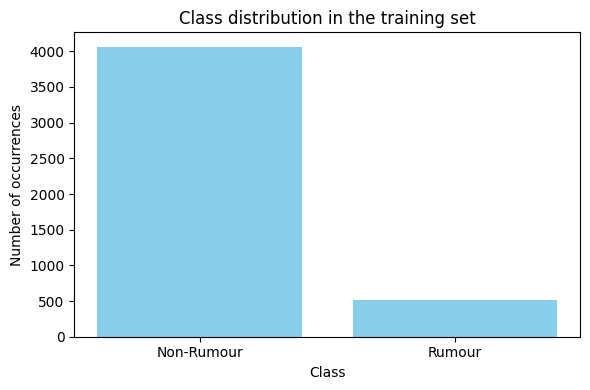

In [23]:
# Calculate number of labels in the training set
labels = [data.y.item() for data in datatrain]
label_counts = Counter(labels)

# Display label distribution
classes = list(label_counts.keys())
counts = list(label_counts.values())
print(label_counts)

plt.figure(figsize=(6,4))
plt.bar(classes, counts, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of occurrences")
plt.title("Class distribution in the training set")
plt.xticks(classes, ["Non-Rumour", "Rumour"])  
plt.tight_layout()
plt.show()


# III. Define GAT model

In [24]:
class GATGraphClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, heads=4, dropout=0.1):
        super().__init__()

        # Graph Attention Layers
        self.gatconv1 = GATConv(input_size, hidden_size, heads=heads, dropout=dropout)
        self.gatconv2 = GATConv(hidden_size * heads, 64, heads=heads, dropout=dropout)
        self.gatconv3 = GATConv(64 * heads, output_size, heads=heads, concat=False, dropout=dropout)

        self.elu = nn.ELU()
        self.dropout = nn.Dropout(dropout)

        # Skip connection projection layers (to match GAT output dimensions)
        self.proj1 = nn.Linear(input_size, hidden_size * heads) if input_size != hidden_size * heads else nn.Identity()
        self.proj2 = nn.Linear(hidden_size * heads, 64 * heads)  # always project for stability
        self.proj3 = nn.Linear(64 * heads, output_size)

    def forward(self, x, edge_index, batch):
        # GAT layer 1 with skip connection
        identity1 = self.proj1(x)
        x = self.gatconv1(x, edge_index)
        x = self.elu(x) + identity1
        x = self.dropout(x)

        # GAT layer 2 with skip connection
        identity2 = self.proj2(x)
        x = self.gatconv2(x, edge_index)
        x = self.elu(x) + identity2
        x = self.dropout(x)

        # GAT layer 3 with skip connection
        identity3 = self.proj3(x)
        x = self.gatconv3(x, edge_index)
        x = x + identity3  # no activation here

        # Global mean pooling to get a graph-level representation
        x = global_mean_pool(x, batch)

        return x



# IV. Best model training

### Class balancing

In [25]:
def compute_class_weights(dataset, power=0.6):
    # Récupère les labels d'entraînement
    train_labels = torch.tensor([data.y.item() for data in dataset])

    # Compte les occurrences
    class_counts = torch.bincount(train_labels)
    class_weights = 1.0 / (class_counts.float() ** power)

    # Normalise les poids pour que la somme = nb de classes
    class_weights = class_weights * (len(class_counts) / class_weights.sum())

    return class_weights


### Training loop


Class weights: tensor([0.4499, 1.5501])
Epoch 0, Train Loss: 0.6193, LR: 0.000020
Validation Loss: 0.6031, Accuracy: 0.8901
Epoch 1, Train Loss: 0.6176, LR: 0.000040
Validation Loss: 0.5896, Accuracy: 0.8901
Epoch 2, Train Loss: 0.5956, LR: 0.000060
Validation Loss: 0.5688, Accuracy: 0.8901
Epoch 3, Train Loss: 0.5755, LR: 0.000080
Validation Loss: 0.5454, Accuracy: 0.8901
Epoch 4, Train Loss: 0.5539, LR: 0.000100
Validation Loss: 0.4913, Accuracy: 0.9075
Epoch 5, Train Loss: 0.5191, LR: 0.000100
Validation Loss: 0.4536, Accuracy: 0.9267
Epoch 6, Train Loss: 0.4897, LR: 0.000100
Validation Loss: 0.4307, Accuracy: 0.9058
Epoch 7, Train Loss: 0.4757, LR: 0.000100
Validation Loss: 0.4512, Accuracy: 0.9302
Epoch 8, Train Loss: 0.4628, LR: 0.000100
Validation Loss: 0.4109, Accuracy: 0.9267
Epoch 9, Train Loss: 0.4568, LR: 0.000100
Validation Loss: 0.4033, Accuracy: 0.9127
Epoch 10, Train Loss: 0.4640, LR: 0.000100
Validation Loss: 0.4007, Accuracy: 0.9058
Epoch 11, Train Loss: 0.4388, LR: 0

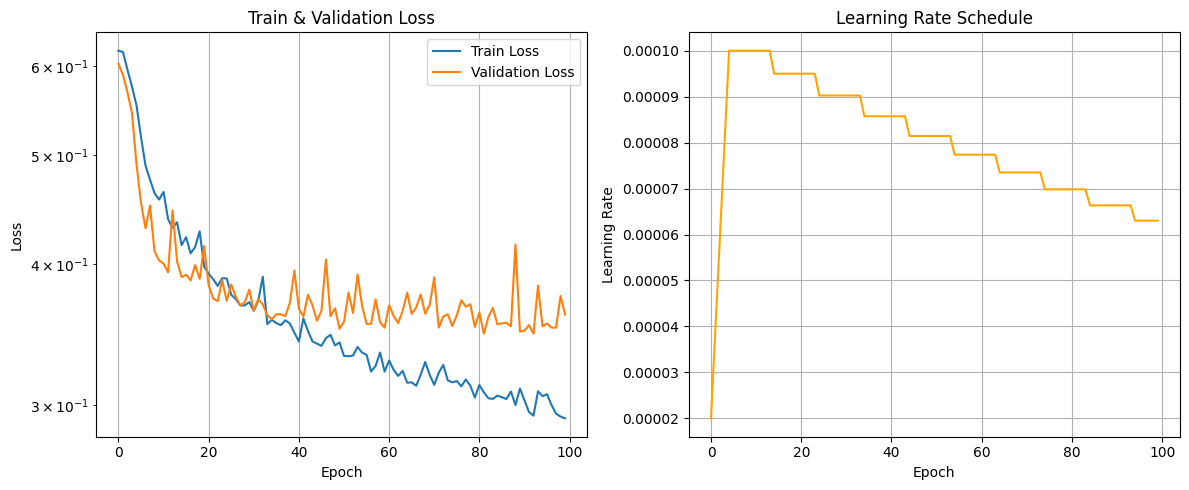

In [26]:
# Create DataLoaders
train_loader = DataLoader(datatrain, batch_size=64, shuffle=True)
val_loader = DataLoader(dataval, batch_size=64, shuffle=True)
test_loader = DataLoader(datatest, batch_size=64, shuffle=True)

# Initialize the model
model = GATGraphClassifier(input_size=dataset[0].x.shape[1], hidden_size=64, output_size=2)

# --- Hyperparameters ---
initial_lr = 0.0001               # Starting learning rate
min_lr = 1e-6                     # Minimum learning rate after decay
weight_decay = 1e-5              # L2 regularization
max_epochs = 100                 # Total number of training epochs
warmup_epochs = max_epochs / 20  # Gradually increase LR during warmup

# Optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)  # Decays LR every 10 epochs

# Compute class weights for imbalanced classification
class_weights = compute_class_weights(datatrain)
print("Class weights:", class_weights)

# Loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Trackers for losses and learning rates
train_losses = []
val_losses = []
lr_history = []

# --- Training loop ---
for epoch in range(max_epochs):
    # --- Learning Rate Warmup ---
    if epoch < warmup_epochs:
        # Linearly increase learning rate
        warmup_lr = initial_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = warmup_lr
    else:
        # Step the scheduler and clamp LR to min_lr
        scheduler.step()
        for param_group in optimizer.param_groups:
            if param_group['lr'] < min_lr:
                param_group['lr'] = min_lr

    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)

    # --- Training ---
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, LR: {current_lr:.6f}")

    # --- Validation ---
    model.eval()
    all_preds = []
    all_labels = []
    epoch_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y)
            epoch_val_loss += loss.item()
            pred = out.argmax(dim=1)
            all_preds.append(pred)
            all_labels.append(batch.y)

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = (all_preds == all_labels).sum().item() / len(all_labels)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {acc:.4f}")

# --- Plot training curves ---
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

# Learning rate schedule
plt.subplot(1, 2, 2)
plt.plot(lr_history, label="Learning Rate", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)

plt.tight_layout()
plt.show()


# V. Best Model Testing

              precision    recall  f1-score     support
0              0.961945  0.881783  0.920121  516.000000
1              0.390000  0.684211  0.496815   57.000000
accuracy       0.862129  0.862129  0.862129    0.862129
macro avg      0.675973  0.782997  0.708468  573.000000
weighted avg   0.905050  0.862129  0.878012  573.000000


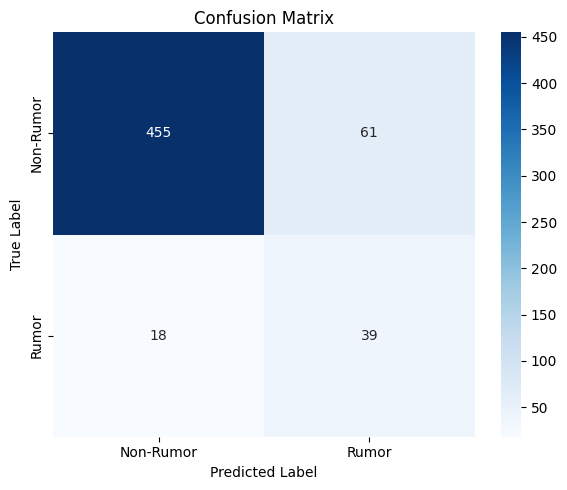

In [27]:
# Set the model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        # Get predicted class (index of max logit)
        preds = out.argmax(dim=1)
        # Store predictions and labels on CPU
        all_preds.append(preds.cpu())
        all_labels.append(batch.y.cpu())

# Concatenate all batches into single arrays
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute detailed classification report (precision, recall, F1)
report_dict = classification_report(all_labels, all_preds, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
print(df_report)

# Compute confusion matrix to visualize prediction errors
conf_mat = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Rumor", "Rumor"],
            yticklabels=["Non-Rumor", "Rumor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
